In [10]:
import sys, os
a_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'python_generated'))
# insert it at front so imports find it first
sys.path.insert(0, a_path)
import message_pb2

In [51]:
experiment = message_pb2.Experiment()
# Read the existing address book.
with open('../data/experiment-1747758492.pb', 'rb') as f:
  experiment.ParseFromString(f.read())

In [31]:
import networkx as nx
G = nx.DiGraph()
for edge in experiment.results[0].original_network.edges:
  G.add_edge(edge.source, edge.target, weight=edge.weight)

In [5]:
experiment.experiment_config.network_config.out_degree_distribution_type#poisson_out_degree_distribution

0

In [29]:
idx = 5
experiment.results[2].perturbations[0].trajectories[0].states[idx].state == experiment.results[2].perturbations[1].trajectories[0].states[idx].state

False

In [19]:
experiment.results[2].perturbations[1].trajectories[0].states[1].state

[True, False, True, False, False, False, True, True, True, False, False, False, False, False, False, True, True, True, False, True, True, False, False, False, True, False, True, False, False, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, False, False, True, False, True, True, False, False, False, False, True, False, False, False, False, True, False, True, True, True, False, True, True, False, False, False, True, True, False, True, True, False, False, True, False, False, False, True, False, False, True, True, False, False, False, False, False, True, True, False, True, False, False, False, True, True, True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, True, True, False, False, False, True, True, False, False, False, True, False, True, False, False, True, False, False, True, True, True, False, True, True, True, False, False, False, True, T

In [52]:
import numpy as np
# (network, drug, initial_condition, time/step, node_idx)
A = np.array([
  np.array([
    np.array([
      np.array([
        np.array(state.state)
        for state in trajectory.states
      ])
      for trajectory in perturbation.trajectories
    ])
    for perturbation in result.perturbations
  ])
  for result in experiment.results
])

In [18]:
A.shape

(1, 1, 1, 51, 50)

In [53]:
# No drug hamming distance.
import pandas as pd
hamming_distance_data = []

for network_idx in range(experiment.experiment_config.num_networks):
  # No drug.
  no_drug_idx = 0
  for initial_condition_idx_1 in range(experiment.experiment_config.dynamics_config.num_initial_conditions):
    for initial_condition_idx_2 in range(initial_condition_idx_1 + 1, experiment.experiment_config.dynamics_config.num_initial_conditions):
      hs = (A[network_idx,no_drug_idx,initial_condition_idx_1] ^ A[network_idx,no_drug_idx,initial_condition_idx_2]).mean(axis=1)
      for step_num, h in enumerate(hs):
        hamming_distance_data.append({
          'network_idx': network_idx,
          'trial_idx': initial_condition_idx_2 * experiment.experiment_config.dynamics_config.num_initial_conditions + initial_condition_idx_1,
          'step_num': step_num,
          'hamming_distance': h,
        })

hamming_distance_df = pd.DataFrame(hamming_distance_data)

In [ ]:
# Drug hamming distance.
import pandas as pd
hamming_distance_data = []

for network_idx in range(experiment.experiment_config.num_networks):
  for drug_idx in range(experiment.experiment_config.drug_config.num_drugs+1):
    for initial_condition_idx in range(experiment.experiment_config.dynamics_config.num_initial_conditions):
      hs = (A[network_idx,0,initial_condition_idx] ^ A[network_idx,drug_idx,initial_condition_idx]).mean(axis=1)
      for step_num, h in enumerate(hs):
        hamming_distance_data.append({
          'network_idx': network_idx,
          'drug_idx': drug_idx,
          'initial_condition_idx': initial_condition_idx,
          'step_num': step_num,
          'hamming_distance': h,
        })

hamming_distance_df = pd.DataFrame(hamming_distance_data)

In [54]:
hamming_distance_df

,network_idx,trial_idx,step_num,hamming_distance
0,0,100,0,0.498
1,0,100,1,0.342
2,0,100,2,0.226
3,0,100,3,0.222
4,0,100,4,0.184
...,...,...,...,...
25244995,99,9998,46,0.174
25244996,99,9998,47,0.174
25244997,99,9998,48,0.174
25244998,99,9998,49,0.174


<Axes: xlabel='step_num', ylabel='hamming_distance'>

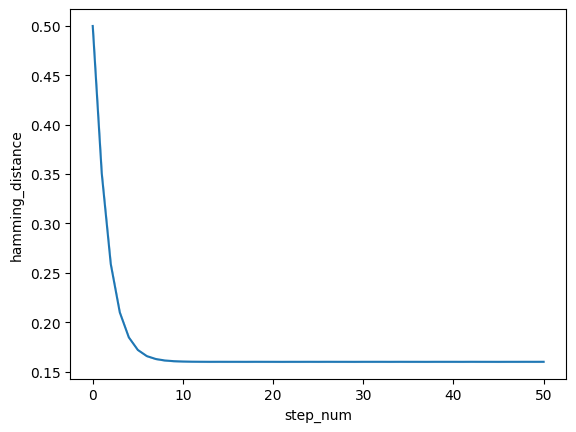

In [55]:
import seaborn as sns
sns.lineplot(
  data=hamming_distance_df,
  x='step_num',
  y='hamming_distance',
)

In [9]:
import networkx as nx
G, G_perturbed = nx.DiGraph(), nx.DiGraph()

In [10]:
for edge in experiment.results[0].perturbations[0].perturbed_network.edges:
  G.add_edge(edge.source, edge.target, weight=edge.weight)

for edge in experiment.results[0].perturbations[1].perturbed_network.edges:
  G_perturbed.add_edge(edge.source, edge.target, weight=edge.weight)

{(0, 0): 0.7639304214661791, (0, 2): -0.13450372088482565, (0, 4): -0.6114246672282402, (0, 5): 0.7845787979706134, (0, 8): -0.7157938231883896, (0, 9): -0.21896385052362222, (5, 0): -0.6800394518346926, (5, 1): -0.9468987420038557, (5, 2): -0.12300401990488075, (5, 3): 0.8424485662725569, (5, 5): -0.9043260377487599, (9, 0): -0.6007179480752338, (1, 3): -0.020656701157347968, (2, 6): -0.4703807535979472, (3, 2): 0.24967972140175876, (7, 2): -0.21703719485031758, (4, 5): 0.2652967460235587, (6, 9): -0.4707934671106888, (8, 6): -0.6178978372830417}


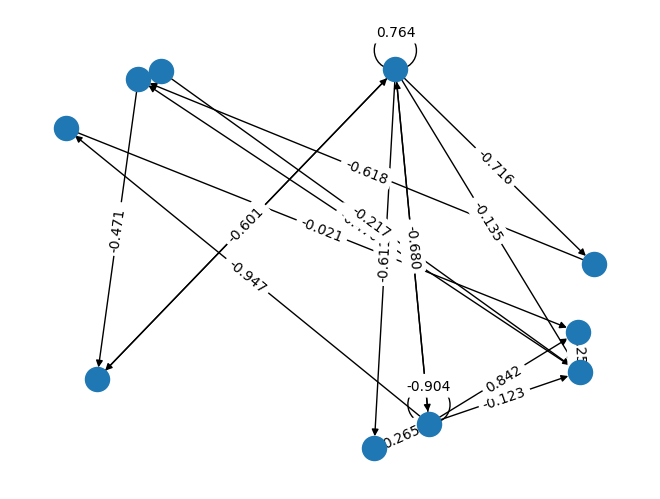

In [19]:
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos=pos)
labels = nx.get_edge_attributes(G, 'weight')
print(labels)
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={loc: f'{weight:.3f}' for loc, weight in labels.items()})

{(0, 0): 0.7639304214661791, (0, 2): -0.13450372088482565, (0, 4): -0.6114246672282402, (0, 5): 0.7845787979706134, (0, 8): -0.7157938231883896, (0, 9): -0.21896385052362222, (5, 0): -0.6800394518346926, (5, 1): -0.9468987420038557, (5, 2): -0.12300401990488075, (5, 3): 0.8424485662725569, (5, 5): -0.9043260377487599, (9, 0): -0.8507179480752338, (1, 3): -0.020656701157347968, (2, 6): -0.4703807535979472, (3, 2): 0.24967972140175876, (7, 2): -0.4670371948503176, (4, 5): 0.2652967460235587, (6, 9): -0.4707934671106888, (8, 6): -0.3678978372830417}


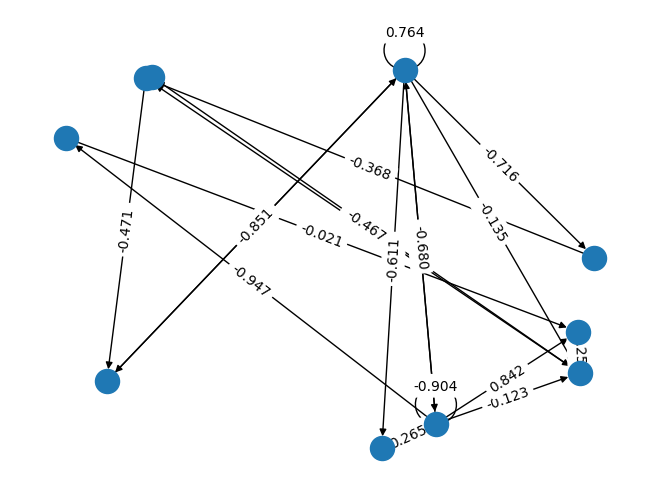

In [18]:
pos = nx.spring_layout(G_perturbed, seed=0)
nx.draw(G_perturbed, pos=pos)
labels = nx.get_edge_attributes(G_perturbed, 'weight')
print(labels)
_ = nx.draw_networkx_edge_labels(G_perturbed, pos=pos, edge_labels={loc: f'{weight:.3f}' for loc, weight in labels.items()})

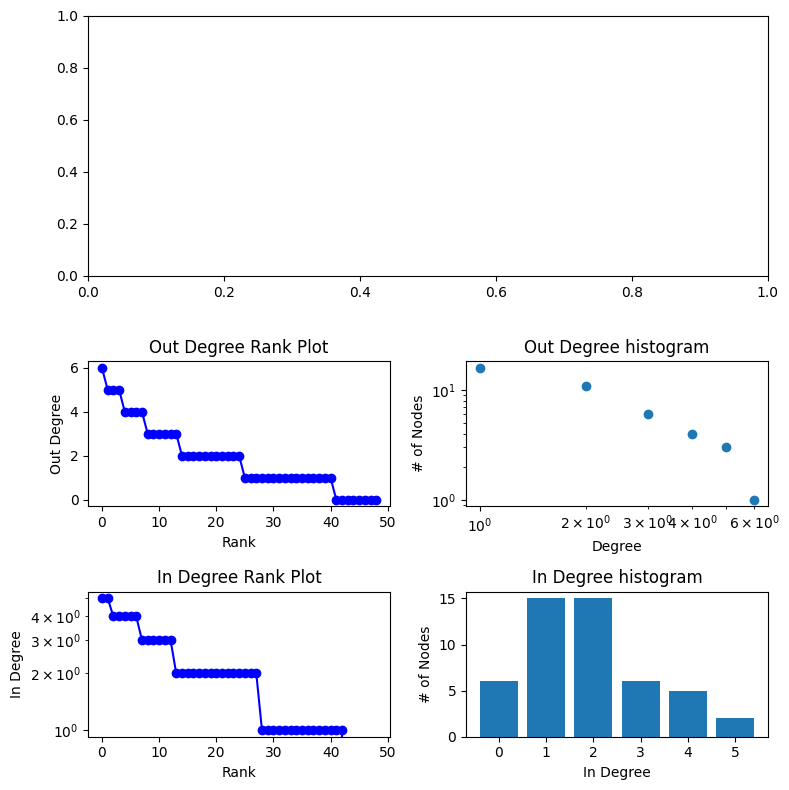

In [9]:
import matplotlib.pyplot as plt
import numpy as np
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
d_out_max = max(out_degree_sequence)
d_in_max = max(in_degree_sequence)

fig = plt.figure("Degrees of power law graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(3+2+2, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
# Gcc = G.subgraph(sorted(nx.strongly_connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(Gcc)
# nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
# nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
# ax0.set_title("Largest strongly Connected component of G")
# ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:5, :2])
ax1.plot(out_degree_sequence, "b-", marker="o")
ax1.set_title("Out Degree Rank Plot")
ax1.set_ylabel("Out Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:5, 2:])
ax2.scatter(*np.unique(out_degree_sequence, return_counts=True))
ax2.set_title("Out Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel("# of Nodes")

ax1 = fig.add_subplot(axgrid[5:7, :2])
ax1.plot(in_degree_sequence, "b-", marker="o")
ax1.set_yscale('log')
ax1.set_title("In Degree Rank Plot")
ax1.set_ylabel("In Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[5:7, 2:])
ax2.bar(*np.unique(in_degree_sequence, return_counts=True))
ax2.set_title("In Degree histogram")
ax2.set_xlabel("In Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [58]:
A = np.array([
  np.array([
    np.array(trajectories.results[trial_idx].states[step_idx].state)
    for step_idx in range(trajectories.dynamics_config.num_steps)
  ])
  for trial_idx in range(trajectories.dynamics_config.num_trials)
])

In [59]:
import pandas as pd
hamming_distance_data = []
for trial_idx_1 in range(trajectories.dynamics_config.num_trials):
  for trial_idx_2 in range(trial_idx_1+1, trajectories.dynamics_config.num_trials):
    hs = (A[trial_idx_1] ^ A[trial_idx_2]).mean(axis=1)
    for t, h in enumerate(hs):
      hamming_distance_data.append({
        'trial_idx_1': trial_idx_1,
        'trial_idx_2': trial_idx_2,
        'time': t,
        'hamming_distance': h,
      })

hamming_distance_df = pd.DataFrame(hamming_distance_data)

In [97]:
np.mean(out_degree_sequence)

np.float64(2.1942)

In [98]:
np.mean(in_degree_sequence)

np.float64(2.1942)

In [89]:
r_nodes = np.random.choice(range(int(1e6)), size=(10,))

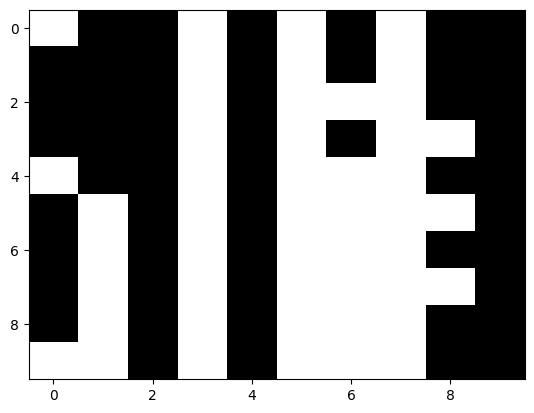

In [96]:
plt.imshow(A[:,6,r_nodes], aspect='auto', cmap='grey')